In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
import rubin_sim.maf as maf

In [3]:
import glob

def read_all_metricdata(workDir, metadata):
    # Just read in ALL metrics in the (joint or single) directory, 
    # Note that this will be REALLY SLOW if you give it many directories.
    if metadata is None:
        matchstring = os.path.join(workDir, '*MOOB.npz')
    else:
        matchstring = os.path.join(workDir, f'*{metadata}*MOOB.npz')
    metricfiles = glob.glob(matchstring)
    metricNames = []
    for m in metricfiles:
        mname = os.path.split(m)[-1].replace('_MOOB.npz', '')
        metricNames.append(mname)

    bdict = {}
    for mName, mFile in zip(metricNames, metricfiles):
        bdict[mName] = maf.createEmptyMoMetricBundle()
        bdict[mName].read(mFile)

    first = bdict[metricNames[0]]
    figroot = f'{first.runName}'
    if metadata != '.':
        figroot += f'_{metadata}'
    return figroot, bdict

def read_metricdata(workDir, metricName, verbose=True):
    # Just read a specific metric output which matches the pattern of metricName
    matchstring = os.path.join(workDir, f'*{metricName}*MOOB.npz')
    metricfiles = glob.glob(matchstring)
    if len(metricfiles) > 1:
        if verbose:
            print(f'Something is maybe wrong - found {len(metricfiles)} files matching {metricName} in {workDir}')
        return
    if len(metricfiles) == 0:
        if verbose:
            print(f'Something is maybe wrong - found no metricfiles matching {metricName} in {workDir}')
        return
    bundle = maf.createEmptyMoMetricBundle()
    bundle.read(metricfiles[0])
    return bundle

In [78]:
# Grab the metadata and science and solar system metrics 
runNames = ['baseline_v2.0_10yrs', 'baseline_nexp2_v1.7.1_10yrs']

# Specific to my setup .. 
ddirs = ['fbs_v2.0/baseline/sims_featureScheduler_runs2.0/baseline', 'fbs_1.7.1/new_rolling']

In [5]:
rc = {}
for tt in ['meta', 'sci']:
    rc[tt] = maf.RunComparison(baseDir='/Users/lynnej/opsim', runNames=runNames, 
                           rundirs=[os.path.join(d, r + '_' + tt) for r, d in zip(runNames, ddirs)])
    mdict = rc[tt].buildMetricDict()
    rc[tt].addSummaryStats(mdict)

In [6]:
rc['sci'].summaryStats.to_csv('new_sci.csv')
rc['meta'].summaryStats.to_csv('new_meta.csv')

In [7]:
objtypes = ['PHA', 'NEO', 'MBA', 'Trojan', 'TNO']
objcolors = {'PHA': 'm', 'NEO': 'r', 'MBA': 'b', 'Trojan': 'g', 'TNO': 'k'}
objorbits = {'PHA': 'granvik_pha_5k', 'NEO': 'granvik_5k', 'MBA': 'mba_5k', 
             'Trojan': 'trojan_5k', 'TNO': 'l7_5k'}
# pandas .plot takes a linestyle argument, so if we have bright/faint value for each population, this should work. 
linestyles = ['g-','g--', 'b-', 'b--', 'y-', 'y--', 'c-', 'c--', 'r-', 'r--']

# Decide where we want to pick out "bright" and "mid" level values.
bright = {}
mid = {}
bright['NEO'] = 16
bright['PHA'] = 16
bright['MBA'] = 16
bright['Trojan'] = 14
bright['TNO'] = 6
mid['NEO'] = 22
mid['PHA'] = 22
mid['MBA'] = 21
mid['Trojan'] = 18
mid['TNO'] = 8

midchar = {}
midchar['NEO'] = 19
midchar['PHA'] = 19
midchar['MBA'] = 18
midchar['Trojan'] = 15
midchar['TNO'] = 7

In [8]:
# Pull out cumulative completeness for various criteria over all objects and runs
criteria = ['3_pairs_in_15_nights_detection_loss',  '3_pairs_in_30_nights_detection_loss']
completeness= {}
for obj in objtypes:
    completeness[obj] = {}
    for crit in criteria:
        completeness[obj][crit] = {}
        metricName = f'CumulativeCompleteness_{obj}_{crit}'
        for run, dd in zip(runNames, ddirs):
            workdir = os.path.join('/Users/lynnej/opsim/', dd, run+"_ss")
            bundle = read_metricdata(workdir, metricName, verbose=True)
            if bundle is not None:
                completeness[obj][crit][run] = bundle

for obj in objtypes:
    for crit in criteria:
        brightMetric = maf.metrics.ValueAtHMetric(Hmark = bright[obj])
        midMetric = maf.metrics.ValueAtHMetric(Hmark = mid[obj])
        for r in runNames:
            try:
                completeness[obj][crit][r].setSummaryMetrics([brightMetric, midMetric])
                # This will save the summary values to the results Db
                completeness[obj][crit][r].computeSummaryStats()
            except KeyError:
                # unfortunately, there were some upstream failures when running metrics, so some are missing
                print(obj, crit, r, 'failure')

runvals = {}
for run in runNames:
    runvals[run] = {}
    for crit in criteria:
        for obj in objtypes:
            try:
                d = completeness[obj][crit][run].summaryValues
                for k in d:
                    hval = float(k.split('=')[-1])
                    cval = d[k]
                    runvals[run][f'{crit.replace("_", " ")} {obj} H={hval}'] = cval
            except KeyError:
                pass
discovery = pd.DataFrame(runvals).T

In [9]:
metric = ['']
fbundles = {}
metricnames = ['FractionPop_1', 'FractionPop_2', 'FractionPop_3', 
               'FractionPop_4', 'FractionPop_5', 'FractionPop_6',
              'FractionPop_Lightcurve_Inversion']
for obj in objtypes:
    fbundles[obj] = {}
    fbundles[obj] = {}
    for mname in metricnames:
        fbundles[obj][mname] = {}
        metricName = f'{mname}_*{obj}'
        for run, dd in zip(runNames, ddirs):
            workdir = os.path.join('/Users/lynnej/opsim/', dd, run+"_ss")
            b = read_metricdata(workdir, metricName, verbose=False)
            if b is not None:
                fbundles[obj][mname][run] = b
                
for obj in objtypes:
    for mname in metricnames:
        brightMetric = maf.ValueAtHMetric(Hmark = bright[obj])
        midMetric = maf.ValueAtHMetric(Hmark = midchar[obj])
        for run in runNames:
            try:
                fbundles[obj][mname][run].setSummaryMetrics([brightMetric, midMetric])
                # This will save the summary values to the results Db
                fbundles[obj][mname][run].computeSummaryStats()
            except KeyError:
                # Here, it may be upstream failures .. but there are also metrics which don't apply to all pops
                pass

runvals = {}
for run in runNames:
    runvals[run] = {}
    for mname in metricnames:
        for obj in objtypes:
            try:
                d = fbundles[obj][mname][run].summaryValues
                # This time, pull up the entire metric name
                mkey = fbundles[obj][mname][run].metric.name
                for k in d:
                    hval = float(k.split('=')[-1])
                    cval = d[k]
                    runvals[run][f'{mkey} {obj} H={hval}'] = cval
            except KeyError:
                pass
characterization = pd.DataFrame(runvals).T

discovery.join(characterization).to_csv('new_sso.csv')

In [10]:
summary = rc['meta'].summaryStats.join(rc['sci'].summaryStats, lsuffix='_m', rsuffix='').join(discovery).join(characterization)

In [22]:
summary.to_csv('new_summary.csv')
summary.T

,baseline_v2.0_10yrs,baseline_nexp2_v1.7.1_10yrs
fOArea fO All visits HealpixSlicer_m,12705.227201,17992.777166
fOArea/benchmark fO All visits HealpixSlicer_m,0.705846,0.999599
fONv MedianNvis fO All visits HealpixSlicer_m,837.000000,888.000000
fONv MinNvis fO All visits HealpixSlicer_m,789.000000,824.000000
fONv/benchmark MedianNvis fO All visits HealpixSlicer_m,1.014545,1.076364
...,...,...
FractionPop Lightcurve Inversion NEO H=19.0,0.049600,0.051800
FractionPop Lightcurve Inversion MBA H=16.0,0.938788,0.969594
FractionPop Lightcurve Inversion MBA H=18.0,0.147830,0.173835
FractionPop Lightcurve Inversion Trojan H=14.0,0.938600,0.986400


In [13]:
summary[[c for c in summary.columns if 'TNO' in c ]]

,3 pairs in 15 nights detection loss TNO H=6.0,3 pairs in 15 nights detection loss TNO H=8.0,3 pairs in 30 nights detection loss TNO H=6.0,3 pairs in 30 nights detection loss TNO H=8.0,FractionPop 1 filters TNO H=6.0,FractionPop 1 filters TNO H=7.0,FractionPop 2 filters TNO H=6.0,FractionPop 2 filters TNO H=7.0,FractionPop 3 filters TNO H=6.0,FractionPop 3 filters TNO H=7.0,FractionPop 4 filters TNO H=6.0,FractionPop 4 filters TNO H=7.0,FractionPop 5 filters TNO H=6.0,FractionPop 5 filters TNO H=7.0,FractionPop 6 filters TNO H=6.0,FractionPop 6 filters TNO H=7.0
baseline_v2.0_10yrs,0.691353,0.468552,0.699142,0.493533,0.6546,0.5554,0.6504,0.5486,0.6094,0.4768,0.5926,0.4198,0.3978,0.1746,0.0180,0.0002
baseline_nexp2_v1.7.1_10yrs,0.684296,0.473288,0.692477,0.500583,0.6470,0.5588,0.6432,0.5526,0.6074,0.4820,0.5944,0.4374,0.3712,0.1840,0.0124,0.0002


(<Figure size 612x360 with 1 Axes>, <RadarAxesSubplot:>)

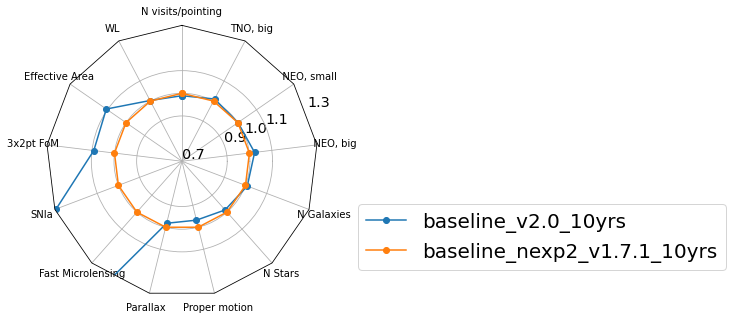

In [57]:
import metric_infos as mi
import run_infos as ri
import radar_plot as rp

from importlib import reload
reload(mi)
reload(rp)

t = summary[mi.radarmetrics]
terr = np.sqrt(summary[mi.radarmetrics])
d= ri.norm_df(t, 'baseline_nexp2_v1.7.1_10yrs', invert_cols=mi.invertradar)
d.columns = mi.radarnames
del d['TDE']
subset = ['baseline_v2.0_10yrs', 'baseline_nexp2_v1.7.1_10yrs'] #, 'baseline_v1.5_10yrs']
rp.radar(d.loc[subset], bbox_to_anchor=(2.5, .1), rgrids=[0.7, 0.9, 1.0, 1.1, 1.3,])

In [58]:
c = ['fOArea_750 fO All visits HealpixSlicer',
    'Effective Area (deg) ExgalM5_with_cuts i band non-DD year 10 HealpixSlicer',
    'fONv MedianNvis fO All visits HealpixSlicer']
d = summary[c].loc[['baseline_v2.0_10yrs', 'baseline_nexp2_v1.7.1_10yrs']]
d.columns = ['SRD Area', 'Dust-free area', 'Median Nvisits/pointing']
d = d.T
d['ratio'] = d['baseline_v2.0_10yrs'] / d['baseline_nexp2_v1.7.1_10yrs']
d

,baseline_v2.0_10yrs,baseline_nexp2_v1.7.1_10yrs,ratio
SRD Area,18606.300821,18140.492848,1.025678
Dust-free area,16706.979302,15108.124907,1.105827
Median Nvisits/pointing,837.000000,846.000000,0.989362


In [59]:
mi.metrics.keys()

dict_keys(['srd', 'Nvis', 'cadence', 'tvs', 'descWFD', 'galaxies', 'sso'])

In [63]:
d = {}
for mset in mi.metrics:
    if not (mset == 'cadence'): #(the cadence metrics here are very simple and misinterpret rolling cadence)
        print(mset)
        d[mset] = pd.DataFrame(summary[mi.metrics[mset]])
        d[mset].columns = mi.short_names[mset]
        d[mset] = d[mset].T
        d[mset]['ratio'] = d[mset]['baseline_v2.0_10yrs'] / d[mset]['baseline_nexp2_v1.7.1_10yrs']

srd
Nvis
tvs
descWFD
galaxies
sso


In [64]:
d['Nvis']

,baseline_v2.0_10yrs,baseline_nexp2_v1.7.1_10yrs,ratio
Nvisits (all),2.084626e+06,2.044984e+06,1.019385
Nvisits (WFD),1.728113e+06,1.706343e+06,1.012758
OpenShutterFraction,7.216614e-01,7.078887e-01,1.019456
Mean Nvisits u,4.843742e+01,5.421870e+01,0.893371
Mean Nvisits g,7.061990e+01,7.231436e+01,0.976568
Mean Nvisits r,1.506248e+02,1.594085e+02,0.944898
Mean Nvisits i,1.529696e+02,1.599768e+02,0.956199
Mean Nvisits z,1.309063e+02,1.399265e+02,0.935536
Mean Nvisits y,1.401363e+02,1.642741e+02,0.853064


In [65]:
d['srd']

,baseline_v2.0_10yrs,baseline_nexp2_v1.7.1_10yrs,ratio
fONv MedianNvis,837.000000,846.000000,0.989362
Med Parallax Error @22.4,2.367301,2.324527,1.018401
Med Parallax Error @24.0,9.573460,9.384408,1.020145
Med PM Error @20.5,0.190862,0.184721,1.033243
Med PM Error @24.0,2.313005,2.215858,1.043842


In [66]:
d['tvs']

,baseline_v2.0_10yrs,baseline_nexp2_v1.7.1_10yrs,ratio
Mean PeriodDetection P=0.5 days,2.966979e+00,2.839290e+00,1.044972
Fast microlensing,4.689000e+03,1.564000e+03,2.998082
TDE AnyColor + u,9.700000e+01,1.050000e+02,0.923810
SNIa,2.556423e+04,1.975521e+04,1.294050
Nstars Precision<0.2mag r,2.629239e+09,2.663423e+09,0.987165
Nstars Precision<0.2mag y,2.570424e+09,2.702766e+09,0.951035


In [67]:
d['descWFD']

,baseline_v2.0_10yrs,baseline_nexp2_v1.7.1_10yrs,ratio
Median coaddedM5 i band,2.617736e+01,2.625682e+01,0.996974
RMS coaddedM5 i band,1.088432e-01,1.132802e-01,0.960832
Effective survey area,1.670698e+04,1.510812e+04,1.105827
3x2pt FoM,3.785265e+01,3.466231e+01,1.092041
3x2pt simple FoM,4.648287e+02,4.228483e+02,1.099280
NGal in exgal footprint,4.566425e+09,4.141437e+09,1.102618
Mean NVisits (WL),1.852606e+02,1.847301e+02,1.002871


In [68]:
d['galaxies']

,baseline_v2.0_10yrs,baseline_nexp2_v1.7.1_10yrs,ratio
NGal all sky,1.200527e+10,1.190403e+10,1.008504


In [70]:
d['sso']

,baseline_v2.0_10yrs,baseline_nexp2_v1.7.1_10yrs,ratio
Completeness PHA H<16.0,0.932400,0.914600,1.019462
Completeness PHA H<22.0,0.581594,0.592684,0.981289
Completeness NEO H<16.0,0.925800,0.904800,1.023210
Completeness NEO H<22.0,0.573562,0.573198,1.000636
Completeness MBA H<16.0,0.994599,1.000000,0.994599
Completeness MBA H<21.0,0.531792,0.574021,0.926433
Completeness Trojan H<14.0,0.999800,1.000000,0.999800
Completeness Trojan H<18.0,0.417768,0.478795,0.872540
Completeness TNO H<6.0,0.691353,0.684296,1.010312
Completeness TNO H<8.0,0.468552,0.473288,0.989993


In [71]:
s = {}
for mset in mi.sso_metrics:
    print(mset)
    s[mset] = pd.DataFrame(summary[mi.sso_metrics[mset]])
    s[mset].columns = mi.sso_short_names[mset]
    s[mset] = s[mset].T
    s[mset]['ratio'] = s[mset]['baseline_v2.0_10yrs'] / s[mset]['baseline_nexp2_v1.7.1_10yrs']

sso disc
Lightcurve Inversion
Fraction Pop 3 bands
Fraction Pop 4 bands
Fraction Pop 5 bands
Fraction Pop 6 bands


In [74]:
s['Lightcurve Inversion']

,baseline_v2.0_10yrs,baseline_nexp2_v1.7.1_10yrs,ratio
Fraction LC Inversion PHA H=16.0,0.461600,0.464200,0.994399
Fraction LC Inversion PHA H=19.0,0.051200,0.054800,0.934307
Fraction LC Inversion NEO H=16.0,0.479600,0.481200,0.996675
Fraction LC Inversion NEO H=19.0,0.049600,0.051800,0.957529
Fraction LC Inversion MBA H=16.0,0.938788,0.969594,0.968228
Fraction LC Inversion MBA H=18.0,0.147830,0.173835,0.850403
Fraction LC Inversion Trojan H=14.0,0.938600,0.986400,0.951541
Fraction LC Inversion Trojan H=15.0,0.111400,0.104000,1.071154


In [75]:
s['Fraction Pop 3 bands']

,baseline_v2.0_10yrs,baseline_nexp2_v1.7.1_10yrs,ratio
Fraction 3 of g and (r or i) and (z or y) PHA H=16.0,0.838800,0.814200,1.030214
Fraction 3 of g and (r or i) and (z or y) PHA H=19.0,0.522000,0.537600,0.970982
Fraction 3 of g and (r or i) and (z or y) NEO H=16.0,0.849400,0.832800,1.019933
Fraction 3 of g and (r or i) and (z or y) NEO H=19.0,0.527400,0.532200,0.990981
Fraction 3 of g and (r or i) and (z or y) MBA H=16.0,0.994399,1.000000,0.994399
Fraction 3 of g and (r or i) and (z or y) MBA H=18.0,0.900980,0.939988,0.958502
Fraction 3 of g and (r or i) and (z or y) Trojan H=14.0,0.999800,1.000000,0.999800
Fraction 3 of g and (r or i) and (z or y) Trojan H=15.0,0.999600,1.000000,0.999600
Fraction 3 filters TNO H=6.0,0.609400,0.607400,1.003293
Fraction 3 filters TNO H=7.0,0.476800,0.482000,0.989212


In [76]:
s['Fraction Pop 4 bands']

,baseline_v2.0_10yrs,baseline_nexp2_v1.7.1_10yrs,ratio
Fraction 4 of grizy PHA H=16.0,0.838600,0.813800,1.030474
Fraction 4 of grizy PHA H=19.0,0.521600,0.537200,0.970961
Fraction 4 of grizy NEO H=16.0,0.849000,0.832800,1.019452
Fraction 4 of grizy NEO H=19.0,0.527200,0.532000,0.990977
Fraction 4 of grizy MBA H=16.0,0.994399,1.000000,0.994399
Fraction 4 of grizy MBA H=18.0,0.900980,0.939988,0.958502
Fraction 4 of grizy Trojan H=14.0,0.999800,1.000000,0.999800
Fraction 4 of grizy Trojan H=15.0,0.999600,1.000000,0.999600
Fraction 4 filters TNO H=6.0,0.592600,0.594400,0.996972
Fraction 4 filters TNO H=7.0,0.419800,0.437400,0.959762


In [77]:
s['Fraction Pop 5 bands']

,baseline_v2.0_10yrs,baseline_nexp2_v1.7.1_10yrs,ratio
Fraction with grizy PHA H=16.0,0.711000,0.676800,1.050532
Fraction with grizy PHA H=19.0,0.303400,0.320400,0.946941
Fraction with grizy NEO H=16.0,0.746600,0.716800,1.041574
Fraction with grizy NEO H=19.0,0.320800,0.334400,0.959330
Fraction with grizy MBA H=16.0,0.989198,0.996999,0.992175
Fraction with grizy MBA H=18.0,0.416483,0.467694,0.890505
Fraction with grizy Trojan H=14.0,0.999200,1.000000,0.999200
Fraction with grizy Trojan H=15.0,0.529000,0.674200,0.784634
Fraction with 5 filters TNO H=6.0,0.397800,0.371200,1.071659
Fraction with 5 filters TNO H=7.0,0.174600,0.184000,0.948913


In [112]:
# Estimate the total number of NEOs discovered

NEOtotal = {}
for r in runNames:
    NEOtotal[r] = {}

def neo_dndh_granvik(hvals):
    y0 = 0 # 10 * np.power(10, 0.55 * (x - 17))
    y1 = 150 * np.power(10, 0.3 * (hvals - 18.5))
    y2 = 2500 * np.power(10, 0.92 * (hvals- 23.2))
    return (y0 + y1 + y2)

# Read differential completeness 
criteria = ['3_pairs_in_15_nights_detection_loss',  '3_pairs_in_30_nights_detection_loss']
Href = 25.0
print(f'Estimating total number of NEOs larger than H={Href}')
diffcompleteness= {}
for obj in ['NEO']:
    diffcompleteness[obj] = {}
    for crit in criteria:
        diffcompleteness[obj][crit] = {}
        metricName = f'DifferentialCompleteness_{obj}_{crit}'
        for run, dd in zip(runNames, ddirs):
            workdir = os.path.join('/Users/lynnej/opsim/', dd, run+"_ss")
            bundle = read_metricdata(workdir, metricName, verbose=True)
            if bundle is not None:
                diffcompleteness[obj][crit][run] = bundle
            else:
                print("problem", obj, crit, run)
                
            # Calculate Number of NEOs (cumulative)
            Hrange = diffcompleteness[obj][crit][run].slicer.slicePoints['H']
            stepsize = np.diff(Hrange).min()
            Hidx = np.where(abs(Hrange - Href) == min(abs(Hrange-Href)))[0]
            binratio = stepsize / 0.1
            # 'NEO Granvik'
            nm_granvik_model =  neo_dndh_granvik(diffcompleteness[obj][crit][run].slicer.slicePoints['H']).cumsum() * binratio
            nm_granvik = (diffcompleteness[obj][crit][run].metricValues[0] * 
                          neo_dndh_granvik(diffcompleteness[obj][crit][run].slicer.slicePoints['H'])).cumsum() * binratio
            NEOtotal[run][f"{crit.replace('_', ' ').replace('detection loss', '')}"] = nm_granvik[Hidx][0]

Estimating total number of NEOs larger than H=25.0


In [113]:
t = pd.DataFrame(NEOtotal)
t['ratio'] = t['baseline_v2.0_10yrs'] / t['baseline_nexp2_v1.7.1_10yrs']
t

,baseline_v2.0_10yrs,baseline_nexp2_v1.7.1_10yrs,ratio
3 pairs in 15 nights,57765.387629,62636.942978,0.922226
3 pairs in 30 nights,66585.527517,74181.464113,0.897603
